In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import cv2
import os
import random
from PIL import Image

from torchvision.transforms import ToTensor
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from pathlib import Path

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import time

import pdb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# image augmentation
random.seed(41)
#Data Tranforms (Augmentation and Normalization)
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomPerspective(distortion_scale=0.4),
                                       transforms.RandomHorizontalFlip(0.6),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(0.6),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

In [ ]:
data_path = "/content/drive/My Drive/VIP_2022_fall_classification"
testing_data_path = "/content/drive/My Drive/VIP_2022_fall_classification/Test (dont use it to train your model)"

# categories = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

train_data = datasets.ImageFolder(data_path + '/Train', transform= train_transforms)
test_data = datasets.ImageFolder(data_path + '/Test (dont use it to train your model)', transform= test_transforms)

# ////////////////////////////////

# train_data_size = len(train_data)
# test_data_size = len(test_data)
# train_data_indices = list(range(train_data_size))

# val_split_index = int(np.floor(0.8 * train_data_size))
# # val_split_index = int(np.floor(0.5 * train_data_size))

# train_idx, val_idx = train_data_indices[:val_split_index], train_data_indices[val_split_index:]

# # train_data = datasets.ImageFolder(data_path + '/Train', transform= train_transforms, subset_indices=list(range(0, val_split_index)))

# train_data_split = torch.utils.data.Subset(train_data, indices=list(range(0, val_split_index)))
# val_data_split = torch.utils.data.Subset(train_data, indices=list(range(val_split_index, train_data_size)))

# train_data_split_size = len(train_data_split)
# # val_data_split_size = len(val_data_split)

# print(train_data_split_size)
# print(val_data_split_size)
# print(train_data_size)
# print(test_data_size)

# # val_data = datasets.ImageFolder(data_path + '/val', transform= valid_transforms)
# valid_data_size = len(val_data_split)


# ///////////////////////////////


# Split the training set into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

# Define the dataloaders for each dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

train_data_size = len(train_data)
test_data_size = len(test_data)
train_data_indices = list(range(train_data_size))

#val_split_index = int(np.floor(0.8 * train_data_size))
val_split_index = int(np.floor(0.3 * train_data_size))

train_idx, val_idx = train_data_indices[:val_split_index], train_data_indices[val_split_index:]

# train_data = datasets.ImageFolder(data_path + '/Train', transform= train_transforms, subset_indices=list(range(0, val_split_index)))

train_data_split = torch.utils.data.Subset(train_data, indices=list(range(0, val_split_index)))
val_data_split = torch.utils.data.Subset(train_data, indices=list(range(val_split_index, train_data_size)))

train_data_split_size = len(train_data_split)
val_data_split_size = len(val_data_split)

valid_data_size = len(val_data_split)

# ////////////////////////////////

classes = dict(zip(list(range(len(train_data.classes))),train_data.classes))
# print(classes)


In [ ]:
batch_size = 32

# # Create data loaders.
# train_dataloader = torch.utils.data.DataLoader(train_data_split, batch_size=batch_size, shuffle = True, num_workers=2)
# val_dataloader = torch.utils.data.DataLoader(val_data_split, batch_size=batch_size, shuffle = True, num_workers=2)
# test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = True, num_workers=2)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [ ]:
# def denormalise(image):
#   try:
#     image = image.cpu().numpy().transpose(1, 2, 0)
#   except:
#     image = image.transpose(1, 2, 0) # PIL images have channel last
#   mean = [0.485, 0.456, 0.406]
#   stdd = [0.229, 0.224, 0.225]
#   image = (image * stdd + mean).clip(0, 1)
#   return image

# dataiter = iter(train_dataloader)
# images, labels = next(iter(train_dataloader))
# images = images.numpy()
# fig = plt.figure(figsize=(15,15))

# for idx in np.arange(25):
#   ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
#   ax.imshow(denormalise(images[idx]), cmap='gray')
#   ax.set_title(classes[labels[idx].item()])

In [ ]:
# Load pretrained ResNet50 Model
# resnet50 = models.resnet50(weights=True)
model = geffnet.create_model('efficientnet_b2', pretrained=True)


# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Changing the Classifier
# fc_inputs = resnet50.fc.in_features
# resnet50.fc = nn.Sequential(torch.nn.Linear(fc_inputs,64),
#                            nn.ReLU(),
#                           #  nn.Dropout(p=0.4),
#                            torch.nn.Linear(64,32),
#                            nn.ReLU(),
#                           #  nn.Dropout(p=0.4),
#                            torch.nn.Linear(32,16),
#                            nn.ReLU(),
#                           #  nn.Dropout(p=0.4),
#                            torch.nn.Linear(16,len(classes)))

# resnet50.fc = nn.Sequential(
#     nn.Linear(fc_inputs, 256),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(256, len(classes)),
#     nn.LogSoftmax(dim=1) # For using NLLLoss()
# )

model.classifier = nn.Sequential(nn.Linear(1408,512),
                           nn.ReLU(),
                           nn.Dropout(p=0.4),
                           nn.Linear(512,128),
                           nn.ReLU(),
                           nn.Dropout(p=0.4),
                           nn.Linear(128,len(classes)))

# # Making the Classifier layer Trainable
# for param in resnet50.classifier.parameters():
#   param.requires_grad = True

# Moving the model to device
model.to(device)

#defining the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=6, gamma=0.35)


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


Batch number: 000, Training: Loss: 0.6441, Accuracy: 0.7969
Batch number: 001, Training: Loss: 0.7306, Accuracy: 0.7188
Batch number: 002, Training: Loss: 0.7755, Accuracy: 0.7656
Batch number: 003, Training: Loss: 0.7028, Accuracy: 0.7656
Batch number: 004, Training: Loss: 0.8248, Accuracy: 0.7500
Batch number: 005, Training: Loss: 0.7269, Accuracy: 0.7812
Batch number: 006, Training: Loss: 0.7386, Accuracy: 0.7812
Batch number: 007, Training: Loss: 0.8166, Accuracy: 0.7500
Batch number: 008, Training: Loss: 0.6018, Accuracy: 0.8281
Batch number: 009, Training: Loss: 0.7364, Accuracy: 0.7812
Batch number: 010, Training: Loss: 0.8052, Accuracy: 0.7656
Batch number: 011, Training: Loss: 0.6648, Accuracy: 0.7031
Batch number: 012, Training: Loss: 0.7109, Accuracy: 0.7344
Batch number: 013, Training: Loss: 0.6390, Accuracy: 0.8438
Batch number: 014, Training: Loss: 0.7794, Accuracy: 0.7031
Batch number: 015, Training: Loss: 0.7328, Accuracy: 0.7500
Batch number: 016, Training: Loss: 0.702

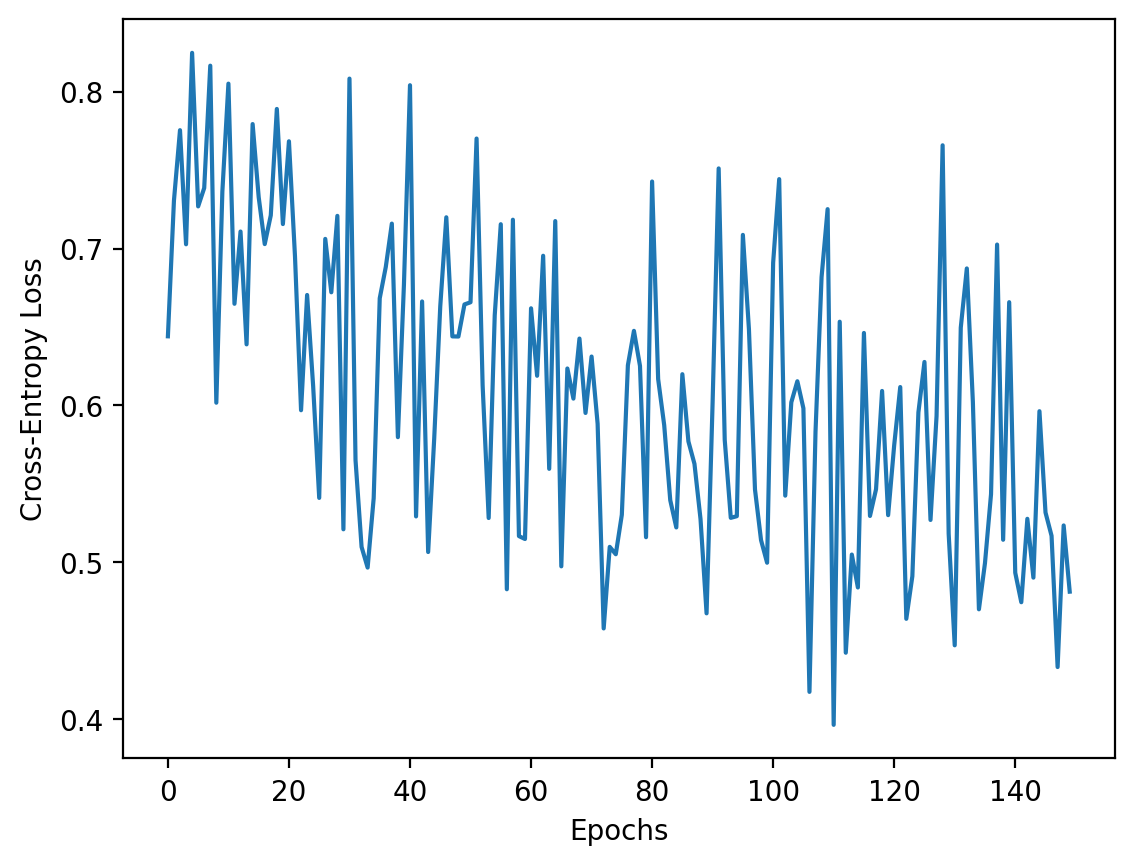

(2408448,)
(16,)
64
Validation Batch number: 000, Validation: Loss: 0.3826, Accuracy: 0.8750
64
Validation Batch number: 001, Validation: Loss: 0.4513, Accuracy: 0.8594
64
Validation Batch number: 002, Validation: Loss: 0.3811, Accuracy: 0.8750
64
Validation Batch number: 003, Validation: Loss: 0.6288, Accuracy: 0.7656
64
Validation Batch number: 004, Validation: Loss: 0.3455, Accuracy: 0.9531
64
Validation Batch number: 005, Validation: Loss: 0.4822, Accuracy: 0.8125
64
Validation Batch number: 006, Validation: Loss: 0.4189, Accuracy: 0.8750
64
Validation Batch number: 007, Validation: Loss: 0.4597, Accuracy: 0.8750
64
Validation Batch number: 008, Validation: Loss: 0.5972, Accuracy: 0.8125
64
Validation Batch number: 009, Validation: Loss: 0.3600, Accuracy: 0.8906
64
Validation Batch number: 010, Validation: Loss: 0.4099, Accuracy: 0.8594
64
Validation Batch number: 011, Validation: Loss: 0.4709, Accuracy: 0.8438
64
Validation Batch number: 012, Validation: Loss: 0.4846, Accuracy: 0.

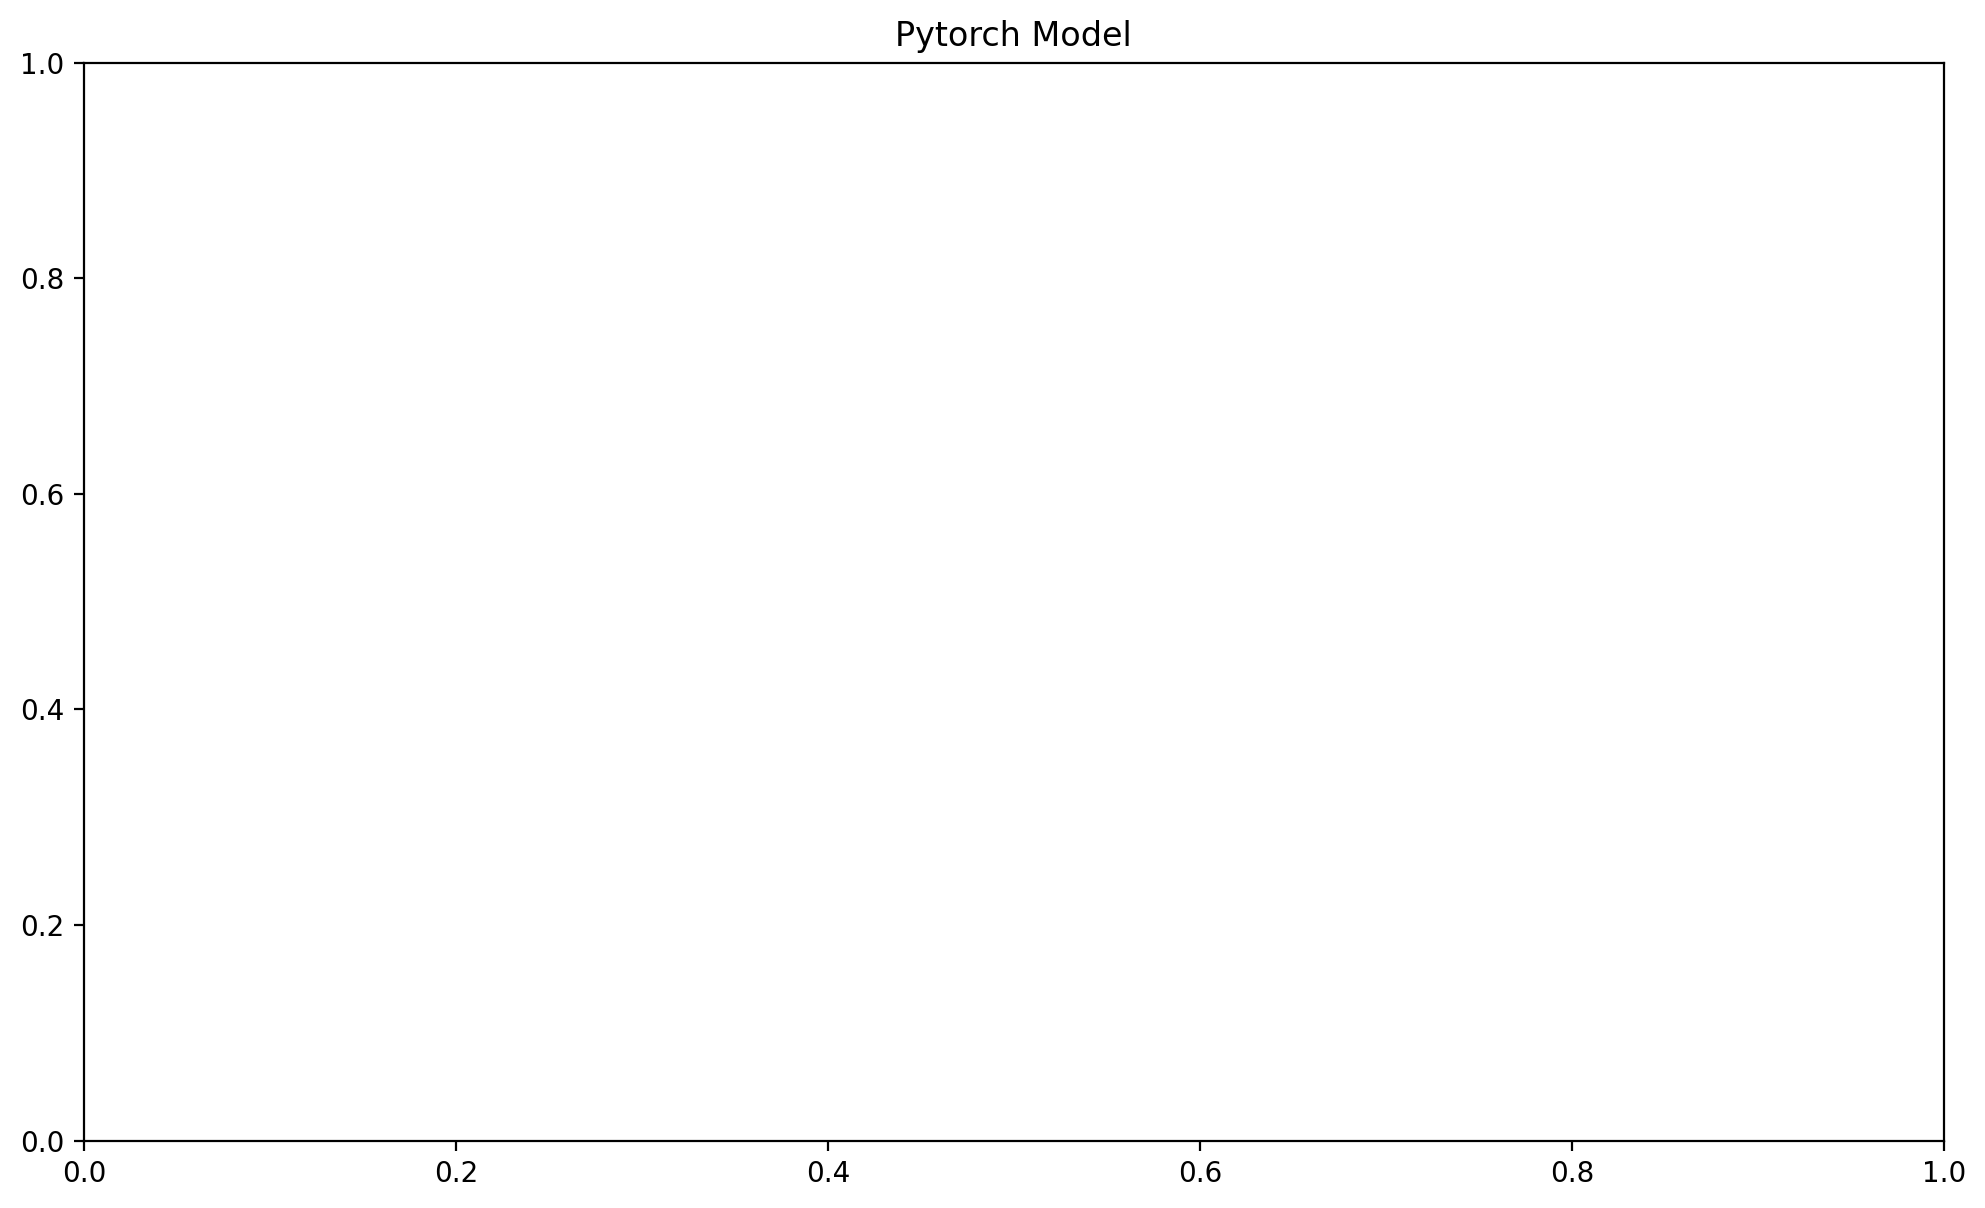

In [ ]:
learning_rate = 1e-4

num_ep = 1
steps = 0

loss_history = []

# Loss and Accuracy within the epoch
train_loss = 0.0
train_acc = 0.0
valid_loss = 0.0
valid_acc = 0.0

for e in range(num_ep):

  train_loss = 0
  model.train()
  #train the model
  for i, (images, labels) in enumerate(train_dataloader):
    steps+=1
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    # Forward Pass
    logits = model(images)
    loss = loss_fn(logits,labels)
    loss_history.append(loss.item())
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Updating the losses list
    train_loss += loss.item() * images.size(0)
    # Compute the accuracy
    ret, predictions = torch.max(logits.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    train_acc += acc.item() * images.size(0)
    print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
    # torch.save()
    # save the model state and optimizer state
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': num_ep,
            'loss': loss
            }, 'model_checkpoint.pt')

scheduler.step()

# Plot your training loss
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.show()

# Find the MSE loss for last epoch
mse = mse = loss_history[-1]

# See how the model fits on training dataset and plot the
y_hat = model(images).cpu().detach().numpy()
plt.figure(figsize=(12,7))
plt.title('Pytorch Model')
# plt.scatter(images, labels, label='Data $(x, y)$')
# plt.scatter(images, labels, label='Data $(x, y)$')
print(images.cpu().numpy().flatten().shape)
print(labels.cpu().numpy().flatten().shape)

# plt.scatter(images.cpu().numpy().flatten(), labels.cpu().numpy().flatten(), label='Data $(x, y)$')

# plt.plot(images, y_hat, color='red', label='Predicted Line $y = f(x)$',linewidth=4.0)
# plt.xlabel('$x$', fontsize=20)
# plt.ylabel('$y$', fontsize=20)
# plt.text(0,0.70,'MSE = {:.3f}'.format(mse), fontsize=20)
# plt.grid(True)
# plt.legend(fontsize=20)
# plt.show()


# Validation
acc_history = []
loss_his = []

with torch.no_grad():
    # Set to evaluation mode
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    # Validation loop
    for j, (images, labels) in enumerate(val_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass - compute outputs on input data using the model
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss_his.append(loss.item())
        valid_loss += loss.item() * images.size(0)
        print(images.size(0))
        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        acc_history.append(acc.item())
        valid_acc += acc.item() * images.size(0)
        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
# Find average training loss and training accuracy
avg_train_loss = train_loss/train_data_split_size
avg_train_acc = train_acc/float(train_data_split_size)
# Find average training loss and training accuracy
avg_valid_loss = valid_loss/val_data_split_size
avg_valid_acc = valid_acc/float(val_data_split_size)
# history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
# history.append(loss.item())
epoch_end = time.time()

# # Plot your validation loss
# plt.plot(history)
# plt.xlabel('Epochs')
# plt.ylabel('Cross-Entropy Loss')
# plt.show()

# print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, nttValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(num_ep, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))




# ........///////////////////............////////////////.........//////////.........../////////////////.......


# ........///////////////////............////////////////.........//////////.........../////////////////.......



# ........///////////////////............////////////////.........//////////.........../////////////////....... confusion below
import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()

    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
#                      columns = [i for i in classes])
images, labels = next(iter(test_dataloader))
labels = labels.detach().cpu().numpy()
print(len(classes))

# labels = labels.data.cpu().numpy()
disp = ConfusionMatrixDisplay(cf_matrix, display_labels = classes)

# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
print(classes[1])
disp.plot()
plt.show()

# plt.figure(figsize = (12,7))
# # sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')


# ///////////////.........../////////////........... f1 score

from sklearn.metrics import precision_recall_curve
!pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve

pred = torch.tensor(y_pred)
true = torch.tensor(y_true)
class_names = list(classes)

target = torch.tensor(class_names)

f1_score = multiclass_f1_score(pred, true, num_classes=6)
print(f1_score)


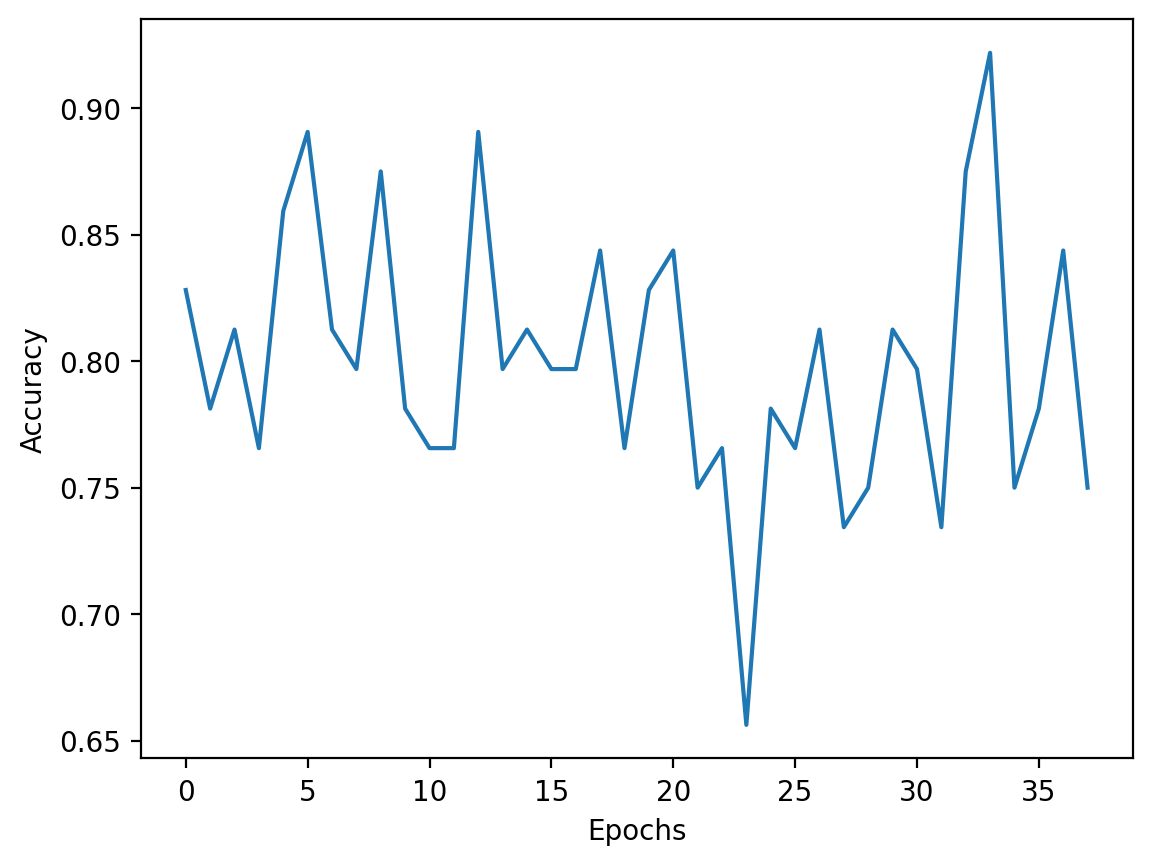

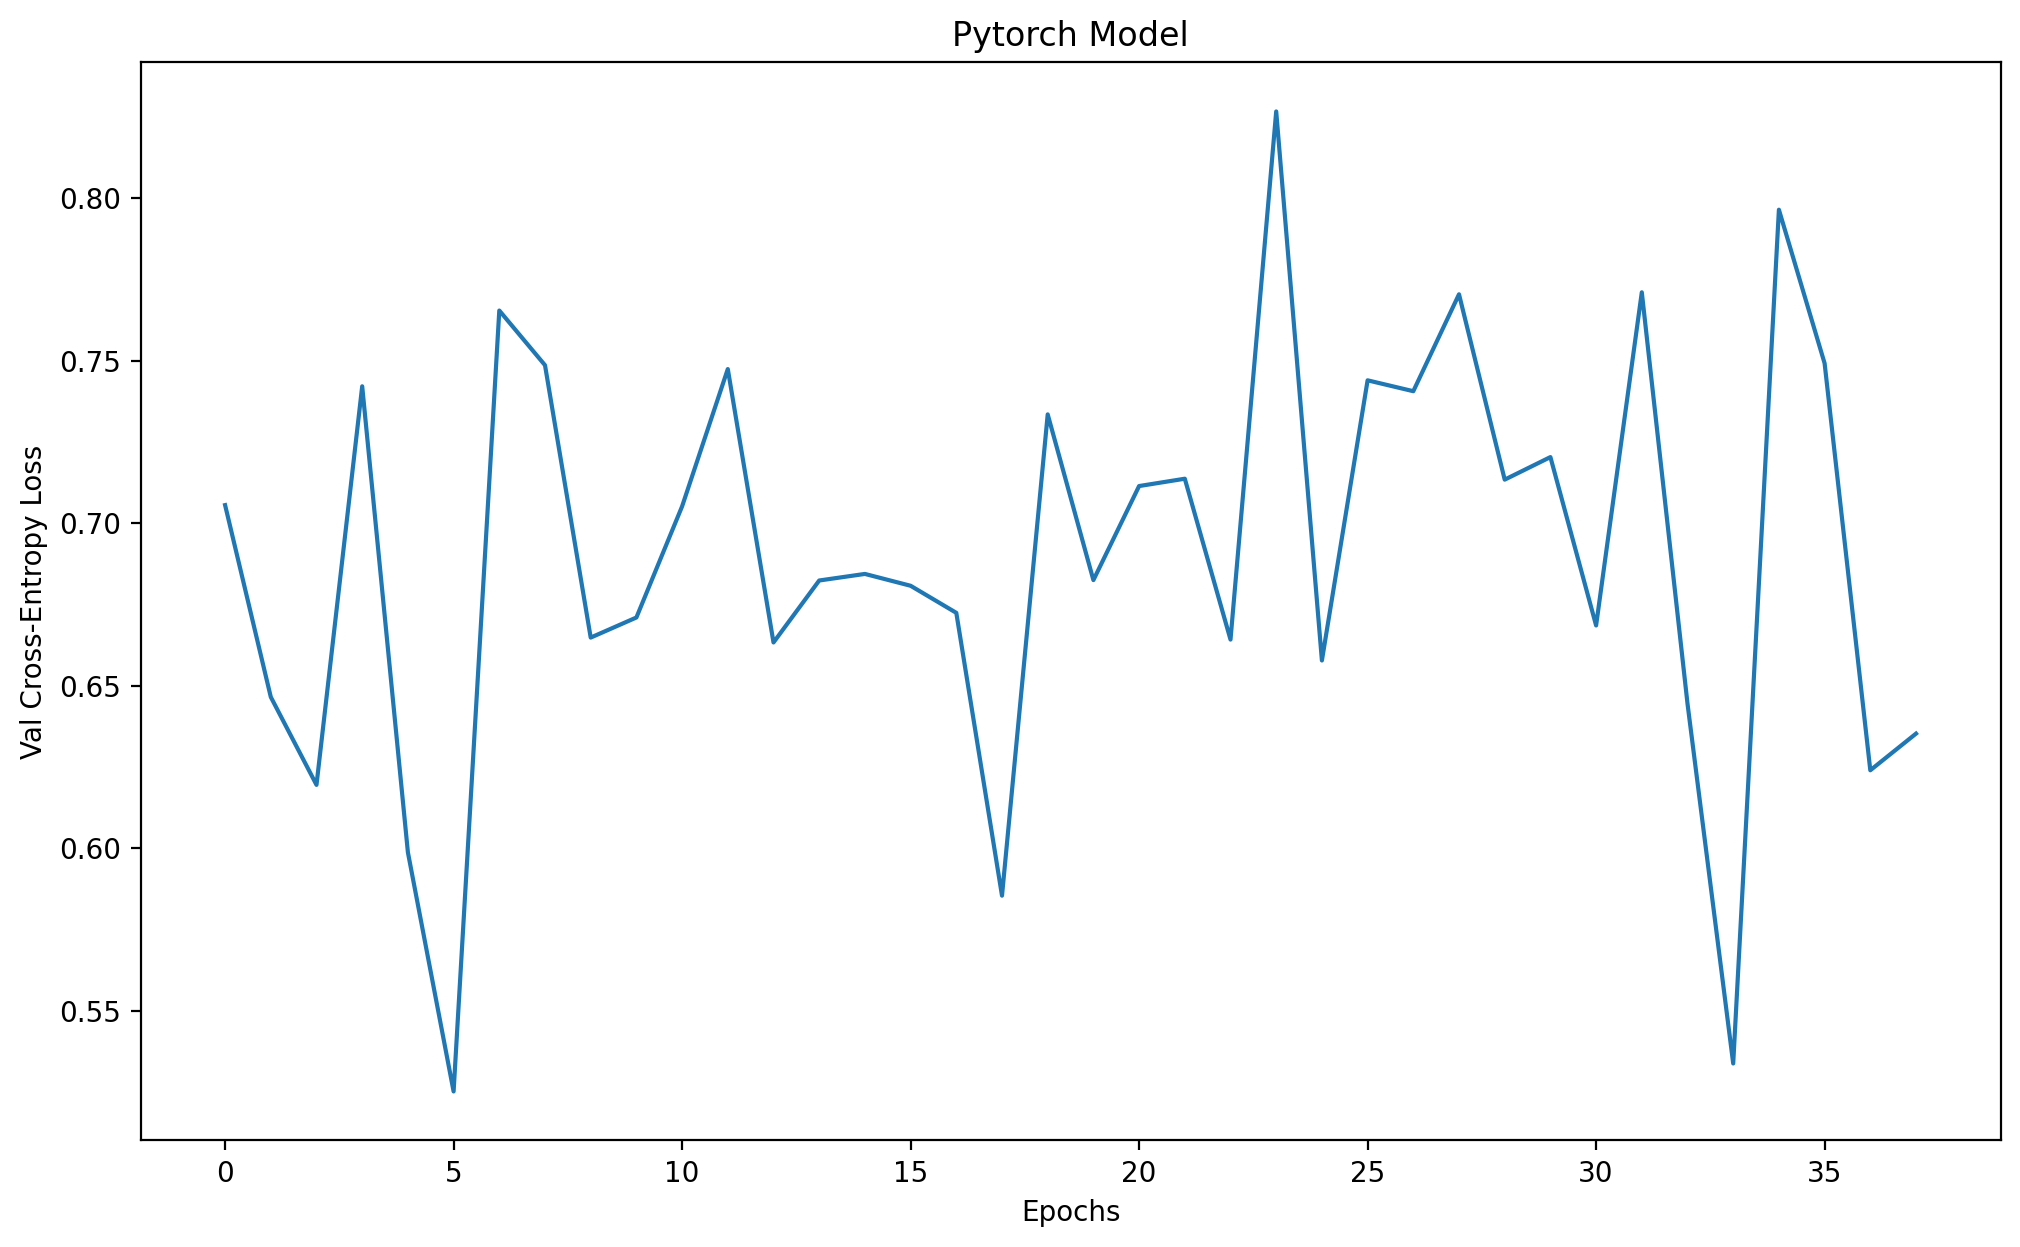

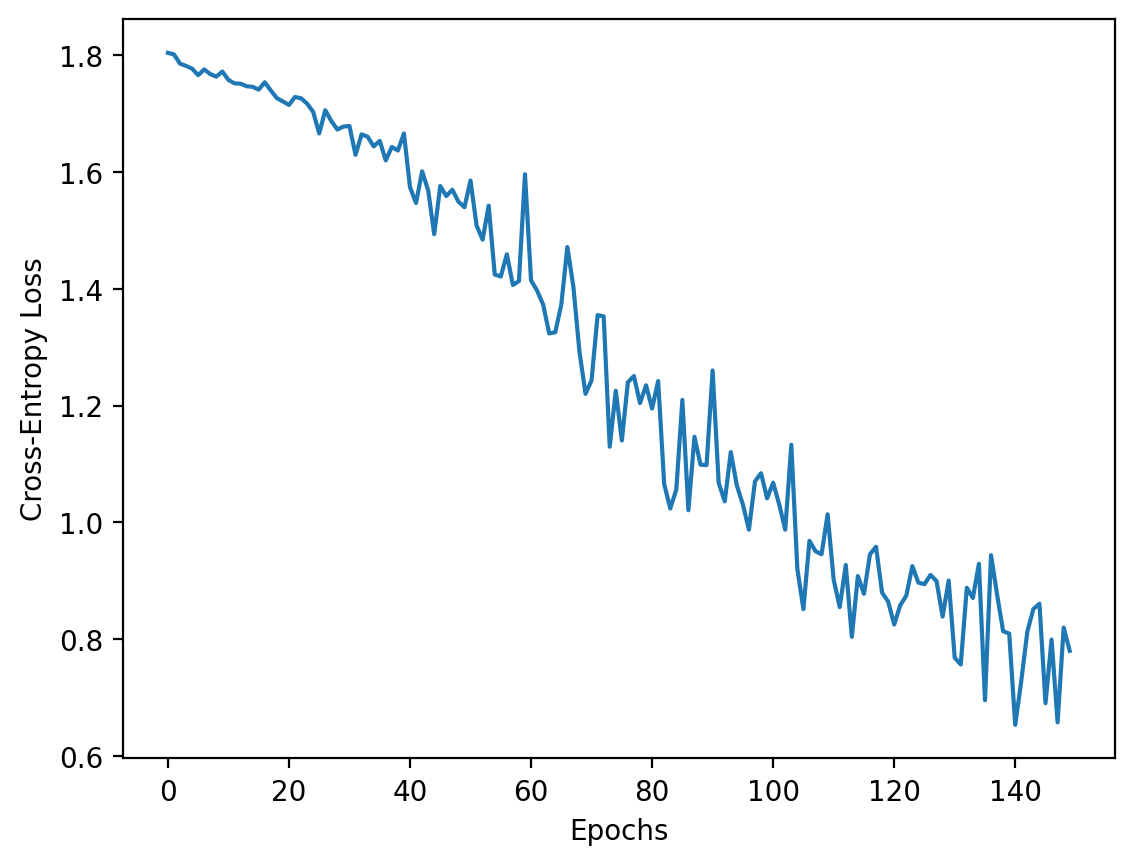

In [ ]:
torch.save(model.state_dict(), 'last_model.pt')

# Plot your validation accuracy
plt.plot(acc_history)
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

# See how the model fits on training dataset and plot the
y_hat = model(images).cpu().detach().numpy()
plt.figure(figsize=(12,7))
plt.title('Pytorch Model')

# Plot your validation loss
plt.plot(loss_his)
plt.xlabel('Epochs')
plt.ylabel('Val Cross-Entropy Loss')
plt.show()



# Plot your training loss
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.show()


In [8]:
# idx_to_class = {v: k for k, v in classes.items()}

# def predict(model, test_image_name):
#     transform = test_transforms
#     test_image = cv2.imread(os.path.join(testing_data_path, test_image_name), cv2.IMREAD_GRAYSCALE)
#     pdb.set_trace()
#     plt.imshow(test_image, cmap='gray')
#     plt.show()
#     test_image_tensor = transform(test_image)
#     if torch.cuda.is_available():
#         test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
#     else:
#         test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
#     with torch.no_grad():
#         model.eval()
#         # Model outputs log probabilities
#         out = model(test_image_tensor)
#         ps = torch.exp(out)
#         topk, topclass = ps.topk(1, dim=1)
#         print("Output class :  ", idx_to_class[topclass.cpu().numpy()[0][0]])
# predict(resnet50, "/mountain/24208.jpg")


In [5]:
# preds  = torch.tensor([2, 0, 2, 1])
# target = torch.tensor([1, 1, 2, 0])
# recall = Recall(task="multiclass", average='macro', num_classes=3)
# recall(preds, target)
# tensor(0.3333)
# recall = Recall(task="multiclass", average='micro', num_classes=3)
# recall(preds, target)

Test Loss: 0.530632

Test Accuracy of     0: 88.10% (1925/2185)
Test Accuracy of     1: 97.05% (2300/2370)
Test Accuracy of     2: 87.52% (2420/2765)
Test Accuracy of     3: 48.76% (1280/2625)
Test Accuracy of     4: 88.43% (2255/2550)
Test Accuracy of     5: 89.02% (2230/2505)

Test Accuracy (Overall): 82.73% (12410/15000)
6
forest


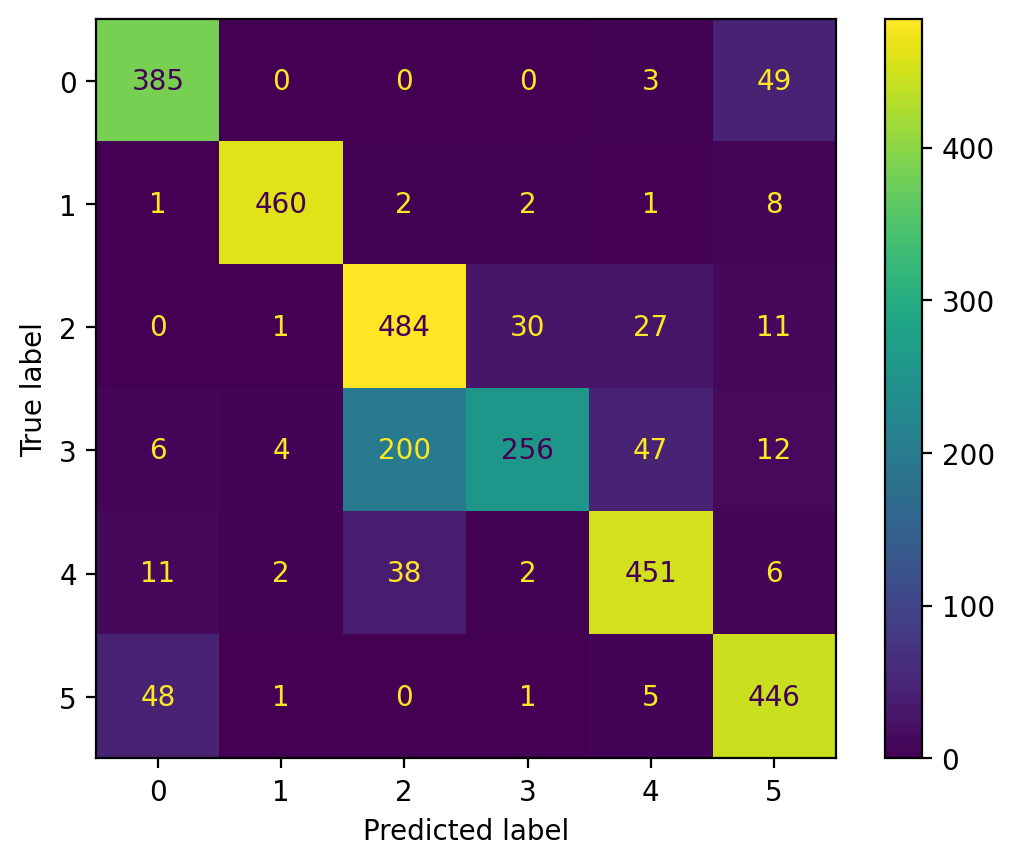

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tensor(0.8273)


In [ ]:
# model.eval() # Prep model for Evaluation

# mean_of = 5 # Mean of how many evaluations
# valid_loss = 0.0
# test_acc = 0.0

# class_correct = list(0. for i in range(len(classes))) # List of number of correct predictions in each class
# class_total = list(0. for i in range(len(classes))) # List of total number of samples in each class
# pred_list = []

# test_loss = []
# acc_list = []

# # for i in range(mean_of):
# for data, target in test_dataloader:
#   # Move the data to device
#   data, target = data.to(device), target.to(device)
#   # forward pass: compute predicted outputs by passing inputs to the model
#   outputs = model(data)
#   # calculate the loss
#   loss = loss_fn(outputs, target)
#   test_loss.append(loss.item());
#   # update test loss
#   valid_loss += loss.item()*data.size(0)
#   # convert output probabilities to predicted class
#   _, pred = torch.max(outputs, 1)
#   pred_list.append(target[pred])
#   # compare predictions to true label
#   correct = np.squeeze(pred.eq(target.data.view_as(pred)))

#   # Calculate validation accuracy
#   ret, predictions = torch.max(outputs.data, 1)
#   correct_counts = predictions.eq(labels.data.view_as(predictions))
#   acc = torch.mean(correct_counts.type(torch.FloatTensor))
#   acc_list.append(acc.item())
#   test_acc += acc.item() * images.size(0)
#   print(acc.item())

#   # calculate test accuracy for each object class
#   for i in range(len(target)):
#       label = target.data[i]
#       if len(target) == 1:
#         class_correct[label] += correct.item()
#       else:
#         class_correct[label] += correct[i].item()
#       class_total[label] += 1

# # calculate and print average test loss
# valid_loss = valid_loss/(mean_of * len(test_dataloader.dataset))
# print('Test Loss: {:.6f}\n'.format(valid_loss))

# # print accuracy of each class
# for i in range(len(classes)):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
#             str(i), 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
# acc = 100. * np.sum(class_correct) / np.sum(class_total)

# # print total accuracy of the model
# print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
#     acc,
#     np.sum(class_correct), np.sum(class_total)))

# # Plot your training loss
# plt.plot(acc_list)
# plt.xlabel('Epochs')
# plt.ylabel('Test Accuracy')
# plt.show()
model.eval() # Prep model for Evaluation

mean_of = 5 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(len(classes))) # List of number of correct predictions in each class
class_total = list(0. for i in range(len(classes))) # List of total number of samples in each class

for i in range(mean_of):
  for data, target in test_dataloader:
    # Move the data to device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = loss_fn(output, target)
    # update test loss
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        if len(target) == 1:
          class_correct[label] += correct.item()
        else:
          class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print average test loss
valid_loss = valid_loss/(mean_of * len(test_dataloader.dataset))
print('Test Loss: {:.6f}\n'.format(valid_loss))

# print accuracy of each class
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
acc = 100. * np.sum(class_correct) / np.sum(class_total)

# print total accuracy of the model
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
    acc,
    np.sum(class_correct), np.sum(class_total)))

# //////////////..........///////////..............///////

import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()

    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
#                      columns = [i for i in classes])
images, labels = next(iter(test_dataloader))
labels = labels.detach().cpu().numpy()
print(len(classes))

# labels = labels.data.cpu().numpy()
disp = ConfusionMatrixDisplay(cf_matrix, display_labels = classes)

# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
print(classes[1])
disp.plot()
plt.show()

# plt.figure(figsize = (12,7))
# # sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')



# //////////.....///////////////....................//////////


from sklearn.metrics import precision_recall_curve
!pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve

pred = torch.tensor(y_pred)
true = torch.tensor(y_true)
class_names = list(classes)

target = torch.tensor(class_names)

f1_score = multiclass_f1_score(pred, true, num_classes=6)
print(f1_score)

In [ ]:
# # Plot your training loss
# plt.plot(acc_list)
# plt.xlabel('Epochs')
# plt.ylabel('Test Accuracy')
# plt.show()

In [10]:
import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()

    y_true.extend(labels) # Save Truth



6
forest


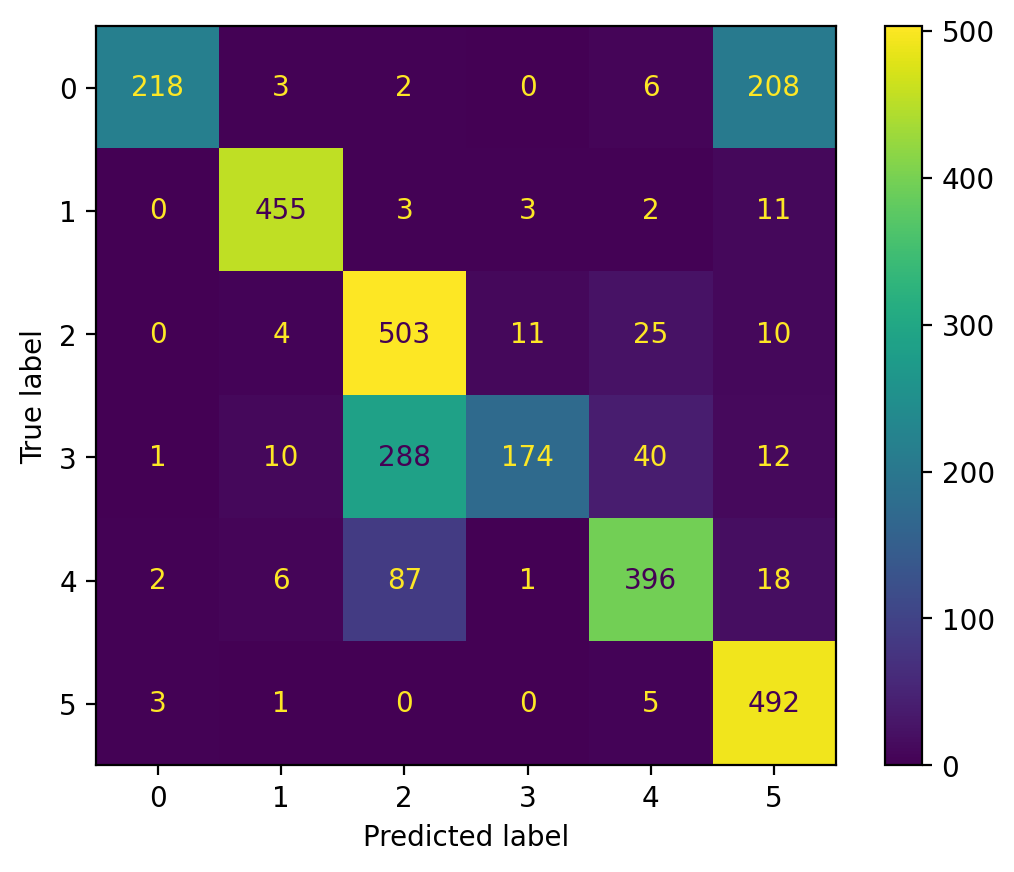

In [ ]:
import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()

    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
#                      columns = [i for i in classes])
images, labels = next(iter(test_dataloader))
labels = labels.detach().cpu().numpy()
print(len(classes))

# labels = labels.data.cpu().numpy()
disp = ConfusionMatrixDisplay(cf_matrix, display_labels = classes)

# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
print(classes[1])
disp.plot()
plt.show()

# plt.figure(figsize = (12,7))
# # sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')



# //////////.....///////////////....................//////////


from sklearn.metrics import precision_recall_curve
!pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve

pred = torch.tensor(y_pred)
true = torch.tensor(y_true)
class_names = list(classes)

target = torch.tensor(class_names)

f1_score = multiclass_f1_score(pred, true, num_classes=6)
print(f1_score)

In [11]:
from sklearn.metrics import precision_recall_curve
!pip install torcheval
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassPrecisionRecallCurve

pred = torch.tensor(y_pred)
true = torch.tensor(y_true)
class_names = list(classes)

target = torch.tensor(class_names)

f1_score = multiclass_f1_score(pred, true, num_classes=6)
print(f1_score)

# metric = MulticlassPrecisionRecallCurve(num_classes=6)
# metric.update(pred, target)
# metric.compute()

# # Plot the curve
# plt.plot(recall, precision)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.show()